In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import itertools
import re

import warnings
warnings.simplefilter('ignore')

In [2]:
item = pd.read_csv('item_to_id.csv')
transaction = pd.read_csv('purchase_history.csv')

item.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
transaction.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [4]:
# unique values
len_item = len(item['Item_id'].unique())
print(f'item_id \t {len_item}')
len_user=len(transaction['user_id'].unique())
print(f'user_id \t {len_user}')

item_id 	 48
user_id 	 24885


In [5]:
# transform 1 ('id') column to several columns
transaction_new = transaction.drop(columns='id').join(transaction['id'].str.split(',',expand = True))

In [12]:
# transform columns names from ids to counts
# ref: https://github.com/stasi009/TakeHomeDataChallenges/blob/master/09.ClusterGrocery/cluster_grocery.ipynb
def id_to_item(df):
    # 'sum' here is adding two lists into one big list
    ids = df['id'].str.split(',').sum()
    id_list = [0 for i in range(1, 49)]
    for i in ids:
        id_list[int(i) - 1] += 1
        
    return pd.Series(id_list, index=list(range(1, 49)))

In [13]:
user_item_count = transaction.groupby('user_id').apply(id_to_item)

user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


In [16]:
# find the users who bought the item mostly
# order by the purchased items amount per customers
user_count = user_item_count.sum(axis = 1).\
                            reset_index().\
                            sort_values(by = 0,ascending = False).\
                            rename(columns = {0:'count'})
user_count.head()

,user_id,count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


In [ ]:
# it shows that the most items amount that customer bought is 72, and the user_id is 269335, 
# which we can consider him/her as most loyalty customer.

In [31]:
# find the users who bought the item mostly, for each item
def item_most_user(df):
    max_count = df['count'].max()
    max_user = df.loc[df['count']==max_count,'user'].values
    return pd.Series([max_user, max_count])

In [44]:
item = pd.read_csv('item_to_id.csv')

In [45]:
item_user_most = data.unstack().reset_index().\
                rename(columns = {'level_0':'item','level_1':'user',0:'count'}).\
                groupby('item').\
                apply(item_most_user).\
                reset_index().\
                rename(columns = {0:'user_id',1:'count'})

In [46]:
item_user_most = item_user_most.merge(item, left_on = 'item', right_on = 'Item_id').drop(columns = 'item')
item_user_most.head()

,user_id,count,Item_name,Item_id
0,"[31625, 540483, 68836, 1301034, 1091637]",8,sugar,1
1,"[31625, 269335]",10,lettuce,2
2,"[1433188, 154960, 593439, 1147269]",8,pet items,3
3,"[432842, 73071, 5289]",6,baby items,4
4,"[397623, 414416, 1392068, 217277]",6,waffles,5


In [ ]:
# Clustering items based on user co-purchase history

In [47]:
# step 1: build item-item similarity matrix
A = normalize(data.values,axis = 0) # A is |U|*|I|
item_item_similarity = A.T.dot(A)
item_item_similarity = pd.DataFrame(item_item_similarity, columns = range(1,49),index = range(1,49))
item_item_similarity.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
1,1.000000,0.506895,0.420145,0.296986,0.271132,0.388250,0.271743,0.335303,0.403690,0.390641,...,0.388034,0.390286,0.358599,0.393056,0.395696,0.396766,0.390253,0.394998,0.392164,0.328221
2,0.506895,1.000000,0.466874,0.322744,0.285125,0.468199,0.312200,0.390521,0.464872,0.527894,...,0.462968,0.462548,0.409401,0.529100,0.464579,0.527325,0.521058,0.462407,0.460257,0.380077
3,0.420145,0.466874,1.000000,0.277325,0.224537,0.358326,0.238133,0.301868,0.362091,0.352597,...,0.351093,0.368199,0.309078,0.357794,0.351209,0.362522,0.361922,0.354933,0.351832,0.297972
4,0.296986,0.322744,0.277325,1.000000,0.162860,0.247414,0.166012,0.216166,0.252662,0.258313,...,0.245623,0.261272,0.210767,0.244946,0.253282,0.253119,0.250190,0.253835,0.260541,0.218717
5,0.271132,0.285125,0.224537,0.162860,1.000000,0.233618,0.164699,0.203245,0.239445,0.234254,...,0.235543,0.238557,0.211006,0.238466,0.235064,0.241835,0.238087,0.238247,0.232387,0.188269


In [48]:
# step 2: # rotate by PCA, making it easier to be visualized later
pca = PCA()
items_rotated = pca.fit_transform(item_item_similarity)
items_rotated = pd.DataFrame(items_rotated,
                             index=data.columns,
                             columns=["pc{}".format(index+1) for index in range(item.shape[0])])

In [49]:
items_rotated

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,...,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48
1,0.355639,-0.025103,-0.051129,-0.039214,-0.049529,0.003300,0.019830,-0.011458,0.084798,-0.042284,...,-0.019760,-0.012837,-0.006332,-0.022289,-0.002654,-0.001332,0.011263,-0.026911,-0.129284,9.332823e-17
2,0.793894,-0.041103,0.013244,-0.009035,-0.141627,-0.036540,-0.114816,-0.087070,0.000959,-0.035030,...,-0.039028,-0.015895,-0.027280,0.017406,0.013680,0.004437,-0.030161,0.006713,0.379136,9.332823e-17
3,0.135668,-0.029584,-0.028246,-0.012556,-0.013317,0.004220,-0.020503,-0.050246,0.177599,-0.080864,...,0.020455,-0.007168,0.040652,0.004387,0.029288,0.000224,0.009908,0.001288,-0.035429,9.332823e-17
4,-0.532034,0.020259,-0.022628,-0.037650,0.022756,-0.046219,0.042124,-0.132828,0.651482,-0.274771,...,0.000133,0.002444,0.005894,-0.003617,-0.005383,0.001555,-0.006114,0.007527,0.020217,9.332823e-17
5,-0.678770,-0.093874,-0.347623,-0.232866,-0.090366,-0.057124,-0.018074,0.038866,-0.048059,-0.014378,...,-0.008466,0.011890,0.002598,0.007605,0.009321,-0.003278,0.006540,0.000677,0.023603,9.332823e-17
6,0.312811,-0.036128,0.044851,0.017309,-0.035048,0.080819,-0.047894,-0.021530,0.119243,0.409097,...,-0.020227,0.037458,-0.003532,-0.068856,0.111363,0.038920,-0.179474,0.195229,-0.039911,9.332823e-17
7,-0.550273,-0.188354,0.058120,0.381101,-0.032518,-0.001882,-0.036626,-0.035533,-0.078704,0.033615,...,-0.003264,0.000230,-0.004935,0.009531,0.007640,0.003959,0.010467,0.000722,0.013446,9.332823e-17
8,-0.052373,0.402611,-0.084719,0.101044,0.061785,0.033619,-0.072494,-0.017836,-0.039679,0.006366,...,0.005499,-0.024467,-0.008533,-0.014347,0.004348,-0.003086,0.009040,-0.013534,-0.003083,9.332823e-17
9,0.337225,-0.088904,-0.039285,-0.046014,-0.062167,0.323283,0.195053,-0.089987,-0.061351,-0.085907,...,0.005030,0.248475,0.074118,-0.045950,-0.022483,-0.111802,-0.022843,-0.095708,0.006773,9.332823e-17
10,0.353093,0.000351,0.014369,-0.014293,-0.208917,-0.091994,-0.284679,-0.144108,-0.051950,-0.104297,...,-0.131877,0.051936,0.032112,0.043657,0.236794,0.033620,0.075691,0.145794,-0.071018,9.332823e-17


In [50]:
# step 3: choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(items_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(items_rotated, kmeans.predict(items_rotated)))

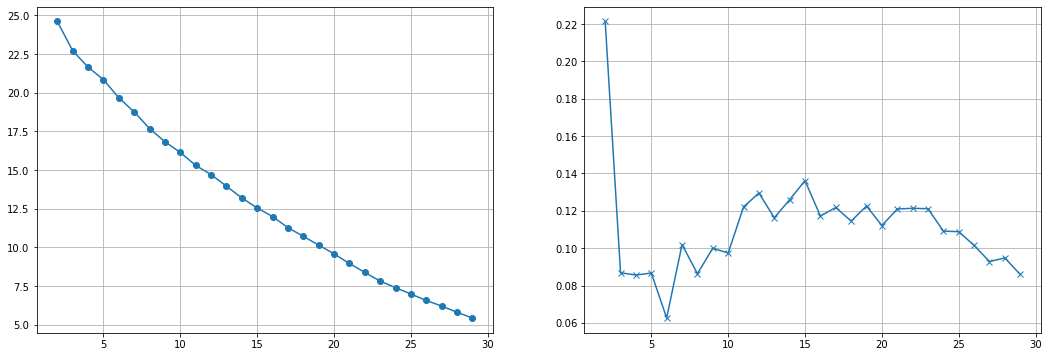

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,6))
ax[0].plot(range(2,30), inertias, 'o-', label='Sum of Squared Distances')# want to use elbow method to find best k
ax[0].grid(True)
ax[1].plot(range(2,30), silhouettes, 'x-', label='Silhouette Coefficient')# the higher the better
ax[1].grid(True)

In [52]:
# either elbow method nor silhouette_score can give better hint about the number of clusters
# have to try multiple K, and choose the best one according to common sense.